In [1]:
import glob 
import numpy as np 
import os 
import shutil 
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator,  load_img, img_to_array, array_to_img 
np.random.seed(42) 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,recall_score

import matplotlib.pyplot as plt 

In [2]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [3]:
IM_SHAPE=(150,150)

In [4]:
filesCOV= glob.glob('D:/dataset/ALL/COVID-19/*')
filesNOCOV=glob.glob('D:/dataset/ALL/Normal/images/*')


In [5]:
COVID = [fn for fn in filesCOV if 'covid' in fn] 
HEALTHY = [fn for fn in filesNOCOV if 'sano' in fn] 

len(COVID), len(HEALTHY)


(11956, 10701)

In [6]:
COVID_train = np.random.choice(filesCOV, size=2500, replace=False) 
HEALTHY_train = np.random.choice(filesNOCOV, size=2500, replace=False) 
filesCOV = list(set(filesCOV) - set(COVID_train)) 
filesNOCOV = list(set(filesNOCOV) - set(HEALTHY_train)) 
 
COVID_val = np.random.choice(filesCOV, size=1000, replace=False) 
HEALTHY_val = np.random.choice(filesNOCOV, size=1000, replace=False) 
filesCOV = list(set(filesCOV) - set(COVID_val)) 
filesNOCOV = list(set(filesNOCOV) - set(HEALTHY_val)) 
 
#COVID_test = np.random.choice(filesCOV, size=1000, replace=False) 
#HEALTHY_test = np.random.choice(filesNOCOV, size=1000, replace=False) 
 
print('Cat datasets:', COVID_train.shape, COVID_val.shape) 
print('Dog datasets:', HEALTHY_train.shape, HEALTHY_val.shape) 

Cat datasets: (2500,) (1000,)
Dog datasets: (2500,) (1000,)


In [7]:
train_dir = 'D:/dataset/DATAOG/train' 
val_dir = 'D:/dataset/DATAOG/valid'
#test_dir = 'C:/Users/hecto/Downloads/MachineCrypto/Proyecto/test' 
 
    
train_files = np.concatenate([COVID_train, HEALTHY_train]) 
validate_files = np.concatenate([COVID_val, HEALTHY_val]) 
#test_files = np.concatenate([COVID_test, HEALTHY_test])
os.mkdir(train_dir) if not os.path.isdir(train_dir) else None 
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None 
#os.mkdir(test_dir) if not os.path.isdir(test_dir) else None 
 
for fn in train_files: 
    shutil.copy(fn, train_dir) 
for fn in validate_files: 
    shutil.copy(fn, val_dir) 
#for fn in test_files: 
#    shutil.copy(fn, test_dir) 
 

In [8]:
IMG_DIM = IM_SHAPE
 
train_files = glob.glob('D:/dataset/DATAOG/train/*') 
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img  
              in train_files] 
train_imgs = np.array(train_imgs) 
train_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in 
                train_files] 

validation_files = glob.glob('D:/dataset/DATAOG/valid/*') 
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for 
                   img in validation_files] 
validation_imgs = np.array(validation_imgs) 
validation_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in 
                     validation_files] 
 
print('Train dataset shape:', train_imgs.shape,  
      'Validation dataset shape:', validation_imgs.shape) 

Train dataset shape: (5000, 150, 150, 3) Validation dataset shape: (2000, 150, 150, 3)


(150, 150, 3)


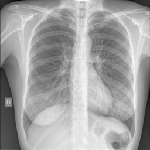

In [9]:
train_imgs_scaled = train_imgs.astype('float32') 
validation_imgs_scaled = validation_imgs.astype('float32') 
train_imgs_scaled /= 255 
validation_imgs_scaled /= 255 
 
# visualize a sample image 
print(train_imgs[0].shape) 
array_to_img(train_imgs[0]) 

In [12]:
for i in range(5000):
    if train_labels[i].find("sano")==-1:
        train_labels[i]='covid'
    else :
        train_labels[i]='sano'
for i in range(2000):
    if validation_labels[i].find("sano")==-1:
        validation_labels[i]='covid'
    else :
        validation_labels[i]='sano'
        

In [13]:
batch_size = 8
num_classes = 2 
epochs = 30 
input_shape = (IM_SHAPE[0],IM_SHAPE[1], 3) 
 
# encode text category labels 
from sklearn.preprocessing import LabelEncoder 
 
le = LabelEncoder() 
le.fit(train_labels) 
train_labels_enc = le.transform(train_labels) 
validation_labels_enc = le.transform(validation_labels) 
 
print(train_labels[190:195], train_labels_enc[195:200]) 

['covid', 'covid', 'covid', 'covid', 'covid'] [0 0 0 0 0]


In [14]:
input_shape

(150, 150, 3)

In [15]:
from keras.applications import MobileNet
from keras.models import Model 
import keras 
resnet=MobileNet(include_top=False,weights='imagenet',  
                                     input_shape=input_shape)

# we have removed the final part of the classifier pertaining to the VGG-16 model 
#since we will be building our own classifier and leveraging VGG as a feature extractor
output = resnet.layers[-1].output 
output = keras.layers.Flatten()(output) 
resnet_model = Model(resnet.input, output) 
resnet_model.trainable = False 
 
for layer in resnet_model.layers: 
    layer.trainable = False 

resnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 75, 75, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 75, 75, 32)       128       
 ation)                                                      

                                                                 
 conv_pw_8 (Conv2D)          (None, 9, 9, 512)         262144    
                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 9, 9, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 9, 9, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 9, 9, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 9, 9, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 9, 9, 512)         0         
                                                                 
 conv_pw_9

In [16]:
# To verify that the layers of the VGG-16 model are frozen, we can use the following code:
import pandas as pd 
pd.set_option('max_colwidth', -1) 
 
layers = [(layer, layer.name, layer.trainable) for layer in 
           resnet_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\hecto\AppData\Local\Temp\ipykernel_11476\3903062396.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000002C026FECA90>,input_1,False
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x000002C0486E7A90>,conv1,False
2,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002C1615609D0>,conv1_bn,False
3,<keras.layers.activation.relu.ReLU object at 0x000002C1617BA8E0>,conv1_relu,False
4,<keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x000002C161793460>,conv_dw_1,False
...,...,...,...
82,<keras.layers.activation.relu.ReLU object at 0x000002C16823C340>,conv_dw_13_relu,False
83,<keras.layers.convolutional.conv2d.Conv2D object at 0x000002C16823CCD0>,conv_pw_13,False
84,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002C16823C6D0>,conv_pw_13_bn,False
85,<keras.layers.activation.relu.ReLU object at 0x000002C1682480A0>,conv_pw_13_relu,False


In [17]:
print("Trainable layers:", resnet_model.trainable_weights)


Trainable layers: []


1/1 [==============================] - 3s 3s/step
(1, 4, 4, 1024)


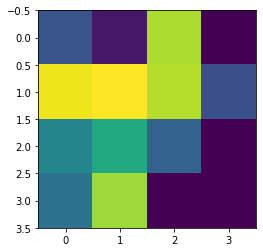

In [18]:
bottleneck_feature_example = resnet.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape) 
plt.imshow(bottleneck_feature_example[0][:,:,0]) 

In [25]:
def get_bottleneck_features(model, input_imgs): 
    features = model.predict(input_imgs, verbose=1, batch_size=32) 
    return features 

train_features_resnet = get_bottleneck_features(resnet_model, 
                                             train_imgs_scaled) 
validation_features_resnet= get_bottleneck_features(resnet_model,      
                                                validation_imgs_scaled) 

print('Train Bottleneck Features:', train_features_resnet.shape, 
      '\tValidation Bottleneck Features:', validation_features_resnet.shape) 

63/63 [==============================] - 1s 21ms/step
Train Bottleneck Features: (5000, 16384) 	Validation Bottleneck Features: (2000, 16384)


In [26]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier

In [27]:
X_train=train_features_resnet
y_train=train_labels_enc
X_valid=validation_features_resnet
y_valid=validation_labels_enc


In [28]:
Acc=[]
Rec=[]
Pre=[]
F1=[]

In [29]:
hist=BaggingClassifier(
base_estimator=DecisionTreeClassifier(),
n_estimators=5
)
hist.fit(X_train,y_train)


hist1=RandomForestClassifier(n_estimators=5)
hist1.fit(X_train,y_train)

hist2=XGBClassifier()
hist2.fit(X_train,y_train)

hist3=LGBMClassifier(n_estimators=1000,class_weight='balanced',
                                       reg_alpha=0.1,reg_lambda=0.1,
                                       learning_rate=0.001,num_leaves=400,boosting='dart'
)
hist3.fit(X_train,y_train)


hist4=AdaBoostClassifier(
base_estimator=DecisionTreeClassifier(),
n_estimators=300
)
hist4.fit(X_train,y_train)


hist5=DecisionTreeClassifier()
hist5.fit(X_train,y_train)



[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


DecisionTreeClassifier()

In [30]:
cm2 = confusion_matrix(y_valid,hist.predict(X_valid))
print(cm2)
acc=accuracy_score(y_valid, hist.predict(X_valid))
print("Accuracy: ",(acc))
recall=recall_score(y_valid, hist.predict(X_valid))
print("Recall: ",(recall))
prec=precision_score(y_valid,hist.predict(X_valid))
print("Precision: ",(prec))
f1=f1_score(y_valid,hist.predict(X_valid))
Acc.append(acc)
Rec.append(recall)
Pre.append(prec)
F1.append(f1)
print("F1-score: ",(f1))

[[832 168]
 [159 841]]
Accuracy:  0.8365
Recall:  0.841
Precision:  0.8334985133795837
F1-score:  0.8372324539571926


In [31]:
cm2 = confusion_matrix(y_valid,hist1.predict(X_valid))
print(cm2)
acc=accuracy_score(y_valid, hist1.predict(X_valid))
print("Accuracy: ",(acc))
recall=recall_score(y_valid, hist1.predict(X_valid))
print("Recall: ",(recall))
prec=precision_score(y_valid,hist1.predict(X_valid))
print("Precision: ",(prec))
f1=f1_score(y_valid,hist1.predict(X_valid))
print("F1-score: ",(f1))
Acc.append(acc)
Rec.append(recall)
Pre.append(prec)
F1.append(f1)

[[822 178]
 [155 845]]
Accuracy:  0.8335
Recall:  0.845
Precision:  0.8260019550342131
F1-score:  0.8353929807217005


In [32]:
cm2 = confusion_matrix(y_valid,hist2.predict(X_valid))
print(cm2)
acc=accuracy_score(y_valid, hist2.predict(X_valid))
print("Accuracy: ",(acc))
recall=recall_score(y_valid, hist2.predict(X_valid))
print("Recall: ",(recall))
prec=precision_score(y_valid,hist2.predict(X_valid))
print("Precision: ",(prec))
f1=f1_score(y_valid,hist2.predict(X_valid))
print("F1-score: ",(f1))
Acc.append(acc)
Rec.append(recall)
Pre.append(prec)
F1.append(f1)

[[925  75]
 [ 88 912]]
Accuracy:  0.9185
Recall:  0.912
Precision:  0.9240121580547113
F1-score:  0.917966784096628


In [33]:
cm2 = confusion_matrix(y_valid,hist3.predict(X_valid))
print(cm2)
acc=accuracy_score(y_valid, hist3.predict(X_valid))
print("Accuracy: ",(acc))
recall=recall_score(y_valid, hist3.predict(X_valid))
print("Recall: ",(recall))
prec=precision_score(y_valid,hist3.predict(X_valid))
print("Precision: ",(prec))
f1=f1_score(y_valid,hist3.predict(X_valid))
print("F1-score: ",(f1))
Acc.append(acc)
Rec.append(recall)
Pre.append(prec)
F1.append(f1)

[[853 147]
 [142 858]]
Accuracy:  0.8555
Recall:  0.858
Precision:  0.8537313432835821
F1-score:  0.855860349127182


In [34]:
cm2 = confusion_matrix(y_valid,hist4.predict(X_valid))
print(cm2)
acc=accuracy_score(y_valid, hist4.predict(X_valid))
print("Accuracy: ",(acc))
recall=recall_score(y_valid, hist4.predict(X_valid))
print("Recall: ",(recall))
prec=precision_score(y_valid,hist4.predict(X_valid))
print("Precision: ",(prec))
f1=f1_score(y_valid,hist4.predict(X_valid))
print("F1-score: ",(f1))
Acc.append(acc)
Rec.append(recall)
Pre.append(prec)
F1.append(f1)

[[771 229]
 [210 790]]
Accuracy:  0.7805
Recall:  0.79
Precision:  0.7752698724239451
F1-score:  0.782565626547796


In [35]:
cm2 = confusion_matrix(y_valid,hist5.predict(X_valid))
print(cm2)
acc=accuracy_score(y_valid, hist5.predict(X_valid))
print("Accuracy: ",(acc))
recall=recall_score(y_valid, hist5.predict(X_valid))
print("Recall: ",(recall))
prec=precision_score(y_valid,hist5.predict(X_valid))
print("Precision: ",(prec))
f1=f1_score(y_valid,hist5.predict(X_valid))
print("F1-score: ",(f1))
Acc.append(acc)
Rec.append(recall)
Pre.append(prec)
F1.append(f1)

[[770 230]
 [221 779]]
Accuracy:  0.7745
Recall:  0.779
Precision:  0.7720515361744301
F1-score:  0.7755102040816326


In [36]:
data=pd.DataFrame([Acc,Rec,Pre,F1])

In [37]:
data

,0,1,2,3,4,5
0,0.836500,0.833500,0.918500,0.855500,0.780500,0.774500
1,0.841000,0.845000,0.912000,0.858000,0.790000,0.779000
2,0.833499,0.826002,0.924012,0.853731,0.775270,0.772052
3,0.837232,0.835393,0.917967,0.855860,0.782566,0.775510


In [39]:
pd.DataFrame.to_csv(data,'data.csv')